# Model Lineage Tracking

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning (ML) workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards.

Tracking entities maintain a representation of all the elements of your end-to-end machine learning workflow. You can use this representation to establish model governance, reproduce your workflow, and maintain a record of your work history. Amazon SageMaker automatically creates tracking entities for trial components and their associated trials and experiments when you create SageMaker jobs such as processing jobs, training jobs, and batch transform jobs. 

In this example, we will collect the model lineage data and represent it in a Heterogeneous Graph to maintain the structure, cohesion and trace lineage data back to its original source.

# Heterogeneous Graphs

Heterogeneous graphs, or heterographs for short, are graphs that contain different types of nodes and edges. The different types of nodes and edges tend to have different types of attributes that are designed to capture the characteristics of each node and edge type. Within the context of graph neural networks, depending on their complexity, certain node and edge types might need to be modeled with representations that have a different number of dimensions. [Source](https://docs.dgl.ai/en/0.4.x/tutorials/hetero/1_basics.html#:~:text=Heterogeneous%20graphs%2C%20or%20heterographs%20for,each%20node%20and%20edge%20type.)


![graph.png](graph.png)
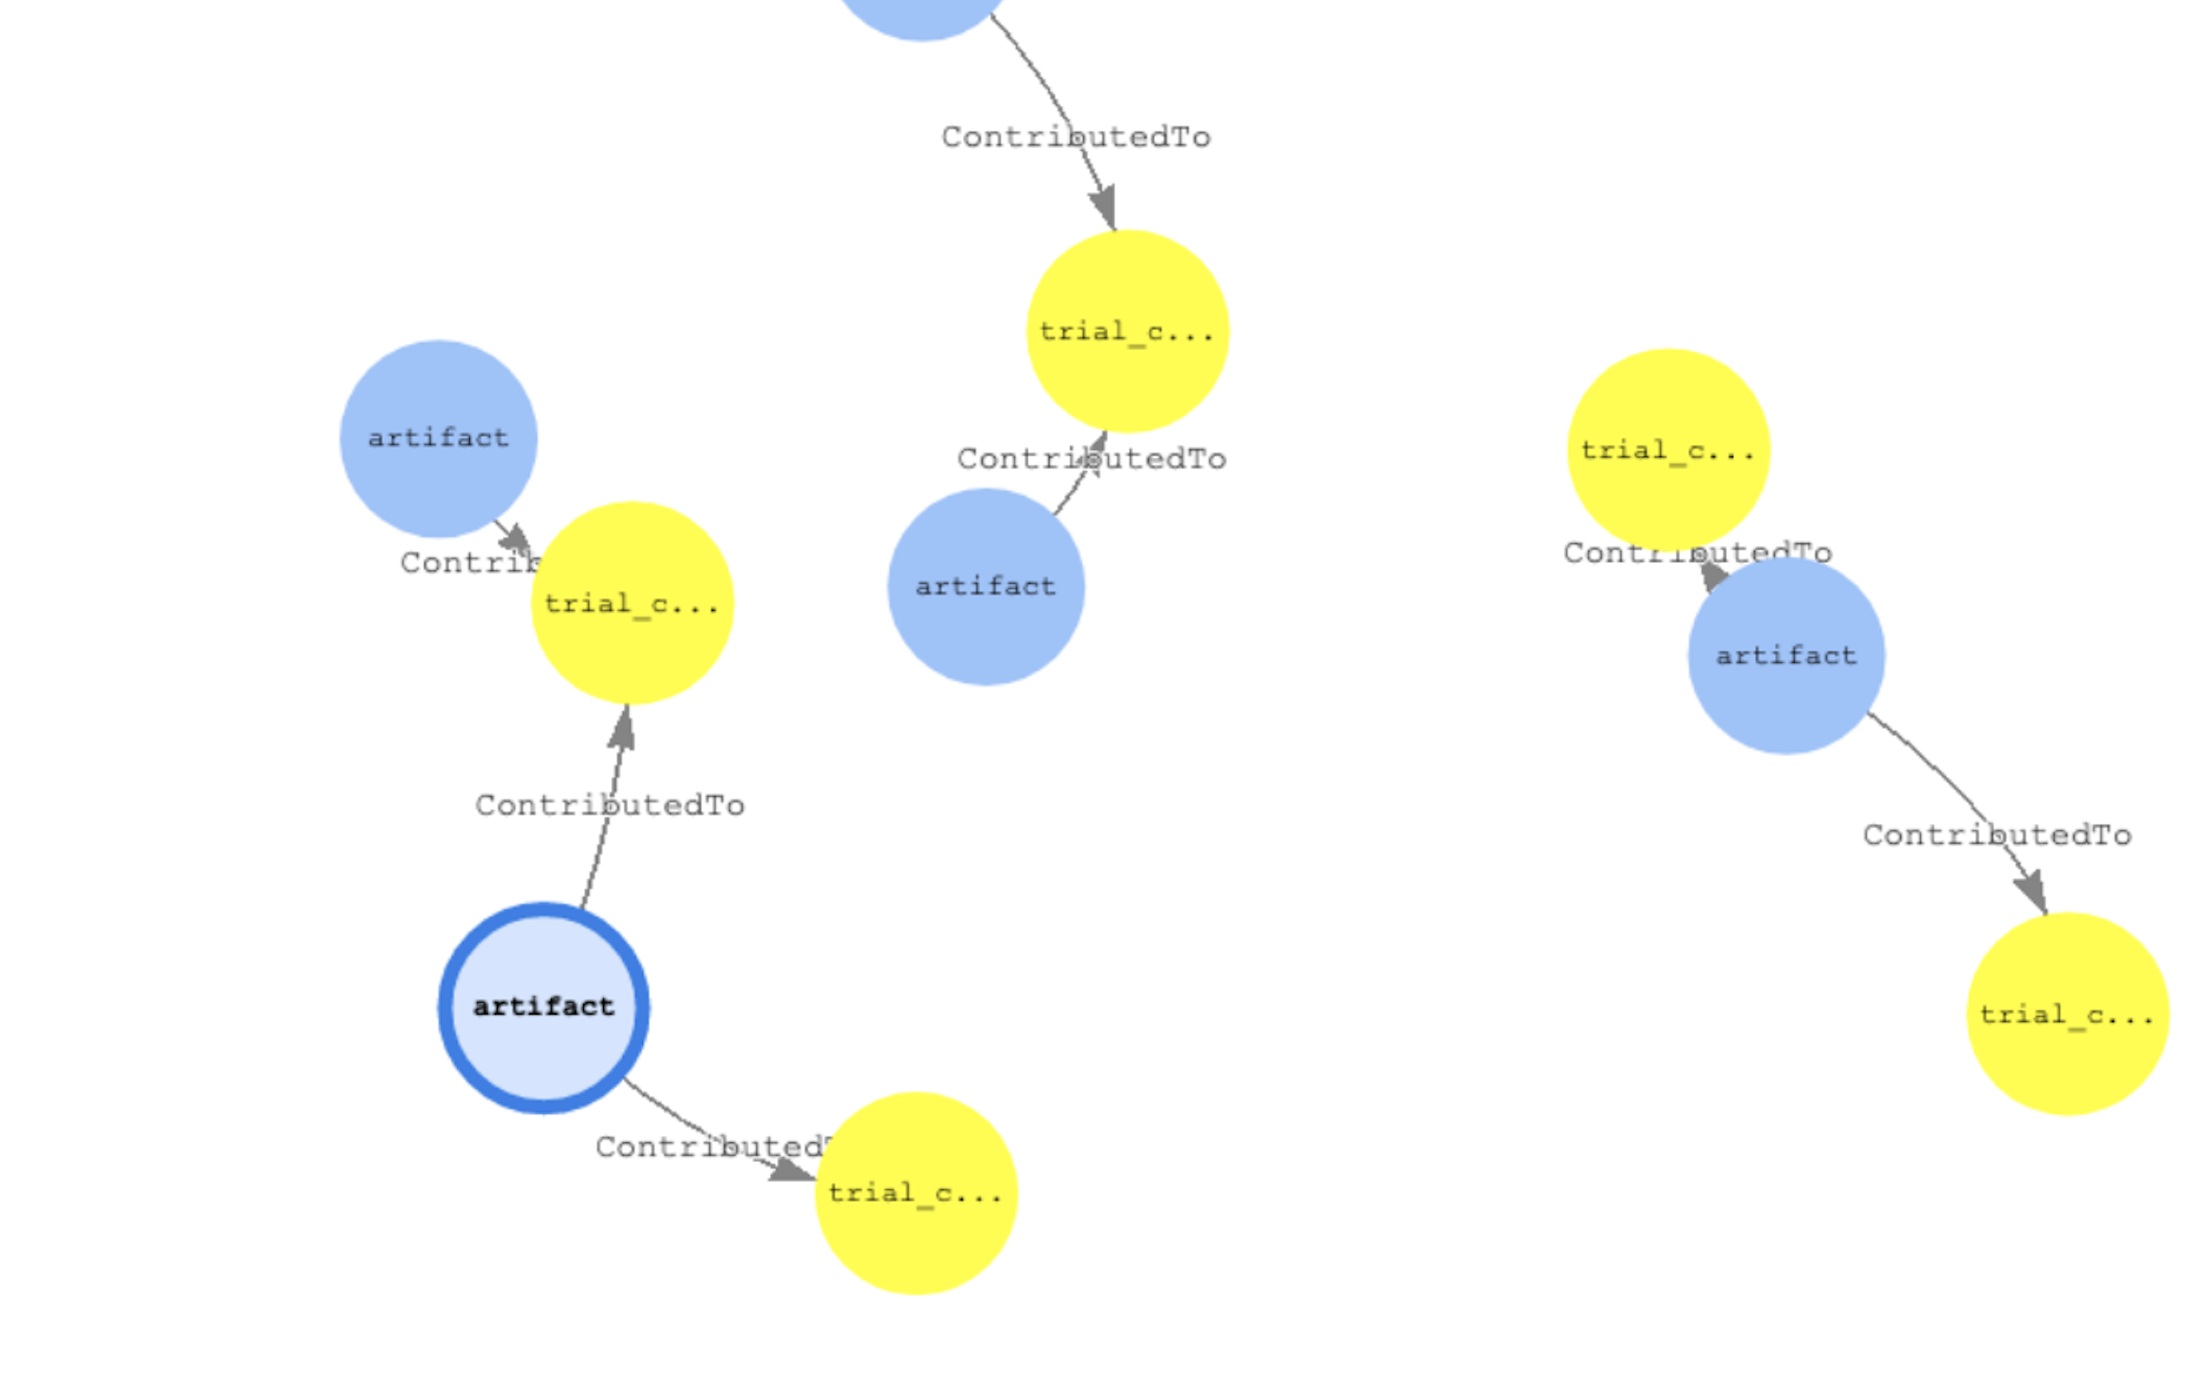

## Import SageMaker Libraries

In [ ]:
!pip install -U sagemaker boto3

In [ ]:
import boto3
from botocore.config import Config
import sagemaker
from sagemaker.lineage import context, artifact, association, action


config = Config(
   retries = {
      'max_attempts': 20,
      'mode': 'adaptive'
   }
)
client = boto3.client('sagemaker', config=config)
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
REGION = boto3.session.Session().region_name
ACCOUNT_ID = boto3.client('sts').get_caller_identity().get('Account')

lookup_dict = {}

## Create the Artifacts Nodes

An artifact is a lineage tracking entity that represents a URI addressable object or data. Some examples are the S3 URI of a dataset and the ECR registry path of an image

In [ ]:
import itertools
p = client.get_paginator('list_artifacts')
paginator = p.paginate().build_full_result()
header='~id,~label,arn:string,sourceuri:string,type:string,creationtime,LastModifiedTime'
counter = itertools.count()
with open("artifacts-nodes.csv", "w") as f:
    f.write(header + '\n')
    for art in paginator['ArtifactSummaries']:
        idd = str(next(counter))
        label = 'artifact'
        arn = art['ArtifactArn']
        sourceuri = art['Source']['SourceUri']
        if 'ArtifactType' in art:
            dtype = art['ArtifactType']
        else:
            dtype = ''
        ctime = art['CreationTime']
        mtime = art['LastModifiedTime']
        line = [idd, label, arn, sourceuri, dtype, ctime, mtime]
        lookup_dict.update({arn: idd})
        f.write(','.join(map(str, line)) + '\n') 

## Create Trial Components Nodes

A trial component is a stage of a machine learning trial. Includes processing jobs, training jobs, and batch transform jobs. In the next cell, we will export all of the trial component data from the account.

In [ ]:
import itertools
import time
tc_actions = client.get_paginator('list_trial_components')
paginator_tcs = tc_actions.paginate().build_full_result()

header='~id,~label,arn:string,sourcearn:string,type:string,creationtime,LastModifiedTime,status:string'
counter = itertools.count()
with open("tcs-nodes.csv", "w") as f:
    f.write(header + '\n')
    for tcs in paginator_tcs['TrialComponentSummaries']:
        idd = 't' + str(next(counter))
        label = 'trial_component'
        arn = tcs['TrialComponentArn']
        if 'TrialComponentSource' in tcs:
            sourcearn = tcs['TrialComponentSource']['SourceArn']
            dtype = tcs['TrialComponentSource']['SourceType']
        else:
            sourcearn = ''
            dtype = ''
        ctime = tcs['CreationTime']
        mtime = tcs['LastModifiedTime']
        mtime = tcs['LastModifiedTime']
        if 'Status' in tcs:
            status = tcs['Status']['PrimaryStatus']
        else:
            status = ''
        line = [idd, label, arn, sourcearn, dtype, ctime, mtime, status]
        lookup_dict.update({arn: idd})
        f.write(','.join(map(str, line)) + '\n') 

##  Create Actions Nodes

Actions represents an action or activity. Generally, an action involves at least one input artifact or output artifact. Some examples are a workflow step and a model deployment.

In [ ]:
import itertools
p_actions = client.get_paginator('list_actions')
paginator_actions = p_actions.paginate().build_full_result()
header='~id,~label,arn:string,sourceuri:string,status:string,type:string,creationtime,LastModifiedTime'
counter = itertools.count()
a = next(counter)

with open("action-nodes.csv", "w") as f:
    f.write(header + '\n')
    for act in paginator_actions['ActionSummaries']:
        idd = 'ac' + str(next(counter))
        label = 'action'
        arn = act['ActionArn']
        sourceuri = act['Source']['SourceUri']
        if 'Status' in act:
            status = act['Status']
        else:
            status = ''
        dtype = act['ActionType']
        ctime = act['CreationTime']
        mtime = act['LastModifiedTime']
        line = [idd, label, arn, sourceuri, status, dtype, ctime, mtime]
        lookup_dict.update({arn: idd})
        f.write(','.join(map(str, line)) + '\n') 

## Create Context Nodes

Contexts are logical grouping of other tracking or experiment entities. Conceptually, experiments and trials are contexts. Some examples are an endpoint and a model package

In [ ]:
import itertools
p_contexts = client.get_paginator('list_contexts')
paginator_contexts = p_contexts.paginate().build_full_result()
header='~id,~label,arn:string,sourceuri:string,status:string,type:string,creationtime,LastModifiedTime'
counter = itertools.count()
a = next(counter)

with open("contexts-nodes.csv", "w") as f:
    f.write(header + '\n')
    for ctx in paginator_contexts['ContextSummaries']:
        idd = 'ctx' + str(next(counter))
        label = 'context'
        arn = ctx['ContextArn']
        sourceuri = ctx['Source']['SourceUri']
        dtype = ctx['ContextType']
        ctime = ctx['CreationTime']
        mtime = ctx['LastModifiedTime']
        line = [idd, label, arn, sourceuri, dtype, ctime, mtime]
        lookup_dict.update({arn: idd})
        f.write(','.join(map(str, line)) + '\n') 

## Create Edges from Associations

An association links other tracking or experiment entities. For example, an association between the location of training data and a training job. This step may take a few hours to finish.

In [ ]:
import itertools
header = '~id,~from,~to,~label'
counter = itertools.count()
with open("edges.csv", "w") as f:
    f.write(header + '\n')
    for key in lookup_dict.keys():
        associations = client.list_associations(DestinationArn=key)['AssociationSummaries']
        if len(associations) > 0:
            for asso in associations:
                if asso['SourceArn'] in lookup_dict:
                    ct = next(counter)
                    idd='e' + str(ct)
                    fr=lookup_dict[asso['SourceArn']]
                    to=lookup_dict[asso['DestinationArn']]
                    if 'AssociationType' in asso:
                        label = str(asso['AssociationType'])
                    else:
                        label = ''
                    line = [idd, fr, to, label]
                    f.write(','.join(map(str, line)) + '\n')                
                    #Sleep every 1000 calls to avoid throttle exception
                    if int(ct) % 1000 == 0:
                        time.sleep(2) 

## Upload the generated files to S3 


In [ ]:
!aws s3 cp edges.csv s3://$BUCKET/sm-model-lineage-export/
!aws s3 cp artifacts-nodes.csv s3://$BUCKET/sm-model-lineage-export/
!aws s3 cp tcs-nodes.csv s3://$BUCKET/sm-model-lineage-export/
!aws s3 cp action-nodes.csv s3://$BUCKET/sm-model-lineage-export/
!aws s3 cp nodes-contexts.csv s3://$BUCKET/sm-model-lineage-export/

## Setup Neptune Cluster and notebook plugin

In the new few steps, we need to create a Neptune cluster either from the public CloudFormation template or manually from the console. After this cell is complete, restart the notebook's kernel.

You can create the Neptune cluster from this [CloudFormation template](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html)

Also, the instructions to install the Graph notebook jupyter extension to visualize the graph from [Here](https://github.com/aws/graph-notebook/#gremlin-server). This is an Jupyter notebook extenstion to make it easy to communicate with Neptune cluster

## Setup Neptune IAM Authentication Policy
Follow the instructions here: https://docs.aws.amazon.com/neptune/latest/userguide/iam-auth-enable.html

## Change Graph config and point to Neptune Endpoint

If you get an error message: "UsageError: Cell magic `%%graph_notebook_config` not found." use Jupyter Notebooks instead of jupyterlab and make sure that you have already installed the Graph extension from [HERE](https://github.com/aws/graph-notebook/#gremlin-server)

```python
%%graph_notebook_config
{
  "host": "localhost", ##Change this value to point to Neptune Cluster.
  "port": 8182,
  "auth_mode": "DEFAULT",
  "iam_credentials_provider_type": "ROLE",
  "load_from_s3_arn": "",
  "ssl": false,
  "aws_region": $REGION 
}
```

## Make sure the configuration for the Neptune cluster is correct

```
%graph_notebook_config
```

## Bulk load data into Neptune

The next section of the code can be converted into code cells after adding the missing variables

```bash
%%bash
    
curl -X POST -H 'Content-Type: application/json' \
    https://<Neptune Cluster Endpoint>:8182/loader -d '
    {
      "source" : "s3://$BUCKET/sm-model-lineage-export/",
      "format" : "csv",
      "iamRoleArn" : "arn:aws:iam::$ACCOUNT_ID:role/NeptuneLoadFromS3",
      "region" : $REGION 
    }'
    
```

## Run a couple of Queries

Let's run a few queries to see some data lineage information. The first query will list all of the artifacts along with directional steps of outward edges and inward vectors

```python

%%gremlin -p v,oute,inv,ine
g.V().hasLabel('artifact').outE().inV().path()

```

Here is an example of another query with more filters. We need to look at all the artifacts of type dataset then display some of its properties like: ARN, type, source ARN and status

```python

%%gremlin -p v,oute,inv,ine
g.V().hasLabel('artifact').has('type','DataSet').outE().inV().path().
    by(valueMap('arn','type','sourcearn','status'))
    
```

## Clean up - Reset the Database

To clean up, you can reset and delete all of the data in the Graph database. This will involve 2 steps:

1- Initiate a database reset.

2- Execute database reset.

```python

%%bash
curl -X POST \
-H 'Content-Type: application/json' \
https://<Neptune Cluster Endpoint>:8182/system \
-d '{ "action" : "initiateDatabaseReset" }'
```

```python

%%bash
curl -X POST -H 'Content-Type: application/json' https://<Neptune Cluster Endpoint>:8182/system -d '
{ 
"action": "performDatabaseReset" ,
"token" : "<Token ID>" #Token ID is the reponse from the previous cell
}'

```